# Problem definition: Segmentation of gliomas in MRI scans

In this jupyter notebook, we will be doing whole tumor (WT) segmentation. WT includes subregions 1, 2 and 4.



Each pixel on image is labelled as :

- Pixel is part of a tumor area (subregions: 1, 2, 4)
- Pixel is not a part of tumor area (0)

where, 0 - no tumor, 1 - necrotic/core/ non-enhancing, 2 - edema, 4 - enhancing


**Objectivies (What will we learn here?)**
1. Setting up the env
2. Create training, validation and test ids
3. Image pre-processing
4. Performance metrics for semantic segmentation
5. Loss functions for semantic segmentation
6. Building the Unet model
7. Training the model
8. Looking at the learning curve
9. Predicting using the Unet model
10. What next? It is time to play!




## Step 1: Set up the env

Download all the packages needed.

In [ ]:
!nvidia-smi

Mon Feb  3 22:48:31 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-12GB           On  | 00000000:82:00.0 Off |                    0 |
| N/A   34C    P0              24W / 250W |      0MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
import numpy as np
from numpy import expand_dims
import cv2
import nibabel as nib
import matplotlib.pyplot as plt
import glob
import pandas as pd
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras.backend as K
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import *
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

tf.config.run_functions_eagerly(True)

print(tf.__version__)

2025-02-03 22:48:34.381365: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-03 22:48:34.501759: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/patel.pranav2/.local/lib/python3.9/site-packages/cv2/../../lib64:/shared/EL9/explorer/cuda/12.1.1/lib64:/shared/EL9/explorer/anaconda3/2024.06/lib:/shared/EL9/explorer/nodejs/v22.11.0/lib
2025-02-03 22:48:34.501785: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-02-03 22:48:37.849508: W te

2.11.1


## Step 2: Now let's create the training, validation and test ids.


In [13]:
# Let's define the train data path.
TRAIN_DATA_PATH = Path('/courses/CS7150.202530/shared/data/MICCAI_BraTS2020_TrainingData/')

# BraTS also has "ValidationData" which has only images and no segmentation masks. So we won't be using it in this notebook.


In [14]:
# Let's create the training, validation and test ids.

train_dir = [f.path for f in os.scandir(TRAIN_DATA_PATH) if f.is_dir()]

# We will create train, validation and test ids from the train_dir dataset


def list_to_ids(dir:str):
    """
    Will convert the dir paths to ids by parsing the paths.
    dir: string, image dir paths in BRATS
    """
    x = []
    for i in range(0,len(dir)):
        x.append(dir[i].split('/')[-1])
    return x



How to do train-test-split using sklearn: https://www.stackvidhya.com/train-test-split-using-sklearn-in-python/

In [15]:
# Now let's use the defined function

ids = list_to_ids(train_dir)

# Split dataset to create training ids, validation ids and test ids
# Here we have selected the size of test set as 20% which is a common practice.
train_ids, test_ids = train_test_split(ids,test_size=0.2)

# Create validation ids by further splitting the train ids, we again use 20% as size of validation set.
# Validation set is also referred to as tuning set.

train_ids, val_ids = train_test_split(train_ids,test_size=0.2)

In [16]:
# Now looks at the number of patient ids in training, validation and test sets
print(f'There are {len(train_ids)} patient ids in training set')
print(f'There are {len(val_ids)} patient ids in validation set')
print(f'There are {len(test_ids)} patient ids in test set')

There are 236 patient ids in training set
There are 59 patient ids in validation set
There are 74 patient ids in test set


## Step 3: Let's do some image pre-processing. You have already learnt basics of reading and visualizing nifti images, selecting slices and looking at histograms.

Here, we will look at some pre-processing steps specific to semantic segmentation. It's important to understand that the pro-processing steps could vary depending on the task at hand.


In [17]:
# Let's rewind and remember the type of images available: T1, T1CE, T2, FLAIR and corresponding masks

# We will use the read_patient_niftis module we had learnt in the previous notebook
def read_patient_niftis(patient_id: str,
                        niftis_to_load = ['t1', 't1ce', 't2', 'flair', 'seg'],
                        data_path = TRAIN_DATA_PATH):
  """
  Will read in the images from a single patient and return a dictionary of
  those images with the key as the image type and the value as the nifti object.
  patient_id: string of format '001' through '369', patient ID in BRATS
  niftis_to_load: default is list containing all the types of images that we care about; can sub in another list if desired.
  data_path: default is DATA_PATH specified above with respect to the mounted google drive (in colab)

  """
  # patient_image_dict = {}
  # for image in niftis_to_load:
  #   patient_image_dict[image]=nib.load(Path(data_path, f'{patient_id}', f'{patient_id}_{image}.nii.gz'))
  # return patient_image_dict
  patient_image_dict = {}
  for image in niftis_to_load:
      nii_gz_path = Path(data_path, f'{patient_id}', f'{patient_id}_{image}.nii.gz')
      nii_path = Path(data_path, f'{patient_id}', f'{patient_id}_{image}.nii')

      # Check for the existence of .nii.gz or .nii files
      if nii_gz_path.exists():
          patient_image_dict[image] = nib.load(nii_gz_path)
      elif nii_path.exists():
          patient_image_dict[image] = nib.load(nii_path)
      else:
          raise FileNotFoundError(f"Neither {nii_gz_path} nor {nii_path} found for {patient_id}")
  return patient_image_dict


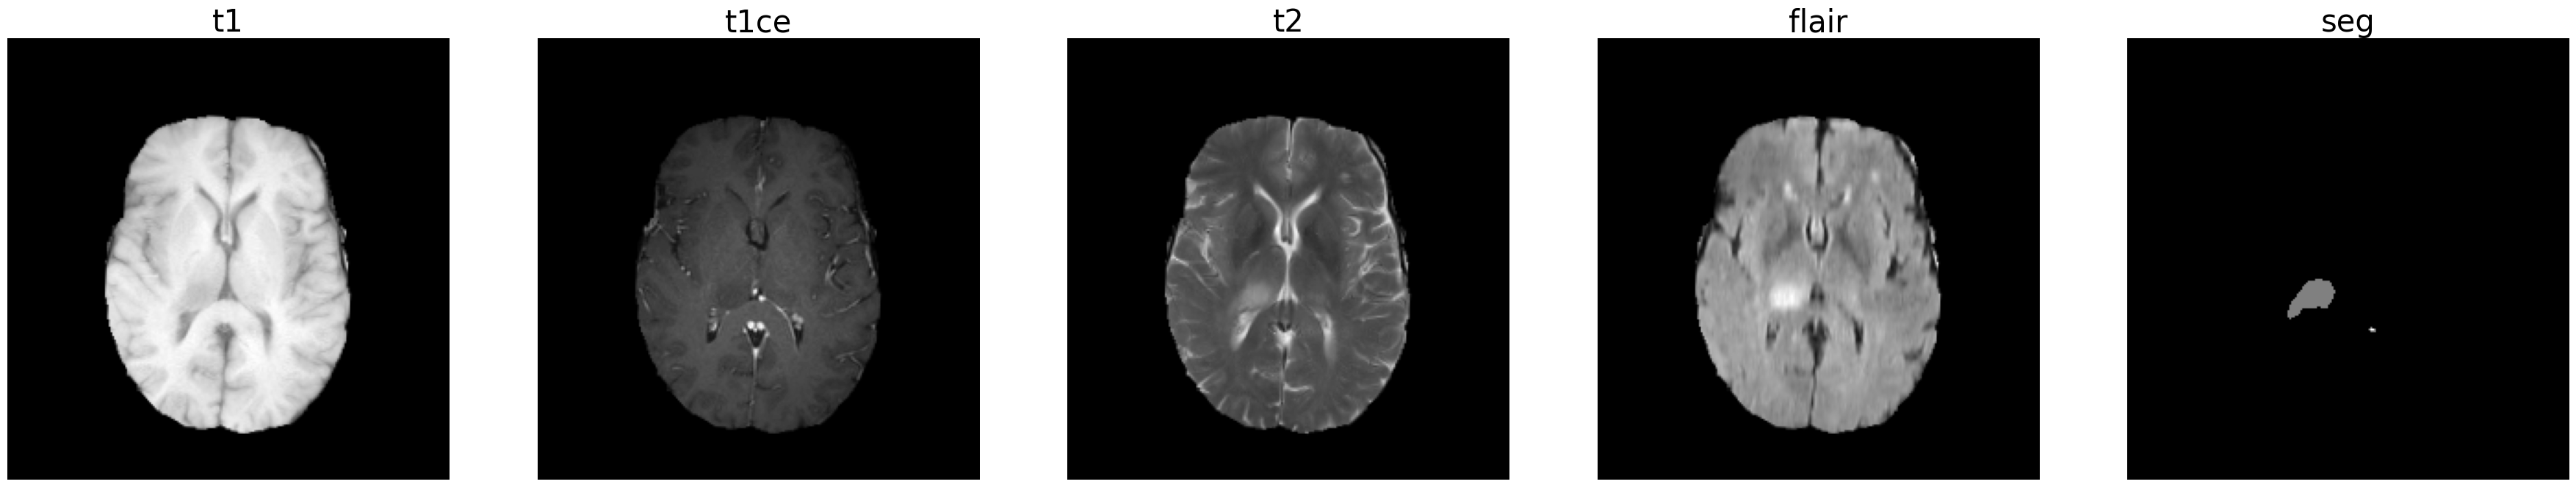

In [18]:
# Let's take a look one of the image and the corresponding segmentation mask from the training set before we proceed
pt_img_dict = read_patient_niftis(train_ids[12])

# Now lets visualize all the images side by side to get a sense of what's happening.
plt.figure(figsize=(45,30)) # specifying the overall grid size
for i, (key, value) in enumerate(pt_img_dict.items()):
    plt.subplot(1, 5, i+1)
    plt.imshow(value._dataobj[:, :, value.shape[-1]//2].T, cmap='gray') # Looks halfway through the volume and transposes the image so that its facing upward.
    plt.axis('off')
    plt.title(key, fontsize=30)
plt.show()

In [19]:
# Updated read_patient_niftis function
def read_patient_niftis(patient_id: str,
                        niftis_to_load=['t1', 't1ce', 't2', 'flair', 'seg'],
                        data_path=TRAIN_DATA_PATH):
    """
    Reads images for a single patient and returns a dictionary of nifti objects.
    Handles both `.nii.gz` and `.nii` file formats.

    Args:
        patient_id (str): Patient ID in BRATS (e.g., 'BraTS20_Training_001').
        niftis_to_load (list): List of image types to load (e.g., ['t1', 't1ce']).
        data_path (str or Path): Path to the dataset.

    Returns:
        dict: Dictionary with keys as image types and values as nifti objects.
    """
    patient_image_dict = {}
    for image in niftis_to_load:
        nii_gz_path = Path(data_path, f'{patient_id}', f'{patient_id}_{image}.nii.gz')
        nii_path = Path(data_path, f'{patient_id}', f'{patient_id}_{image}.nii')

        # Check for the existence of .nii.gz or .nii files
        if nii_gz_path.exists():
            patient_image_dict[image] = nib.load(nii_gz_path)
        elif nii_path.exists():
            patient_image_dict[image] = nib.load(nii_path)
        else:
            raise FileNotFoundError(f"Neither {nii_gz_path} nor {nii_path} found for {patient_id}")
    return patient_image_dict


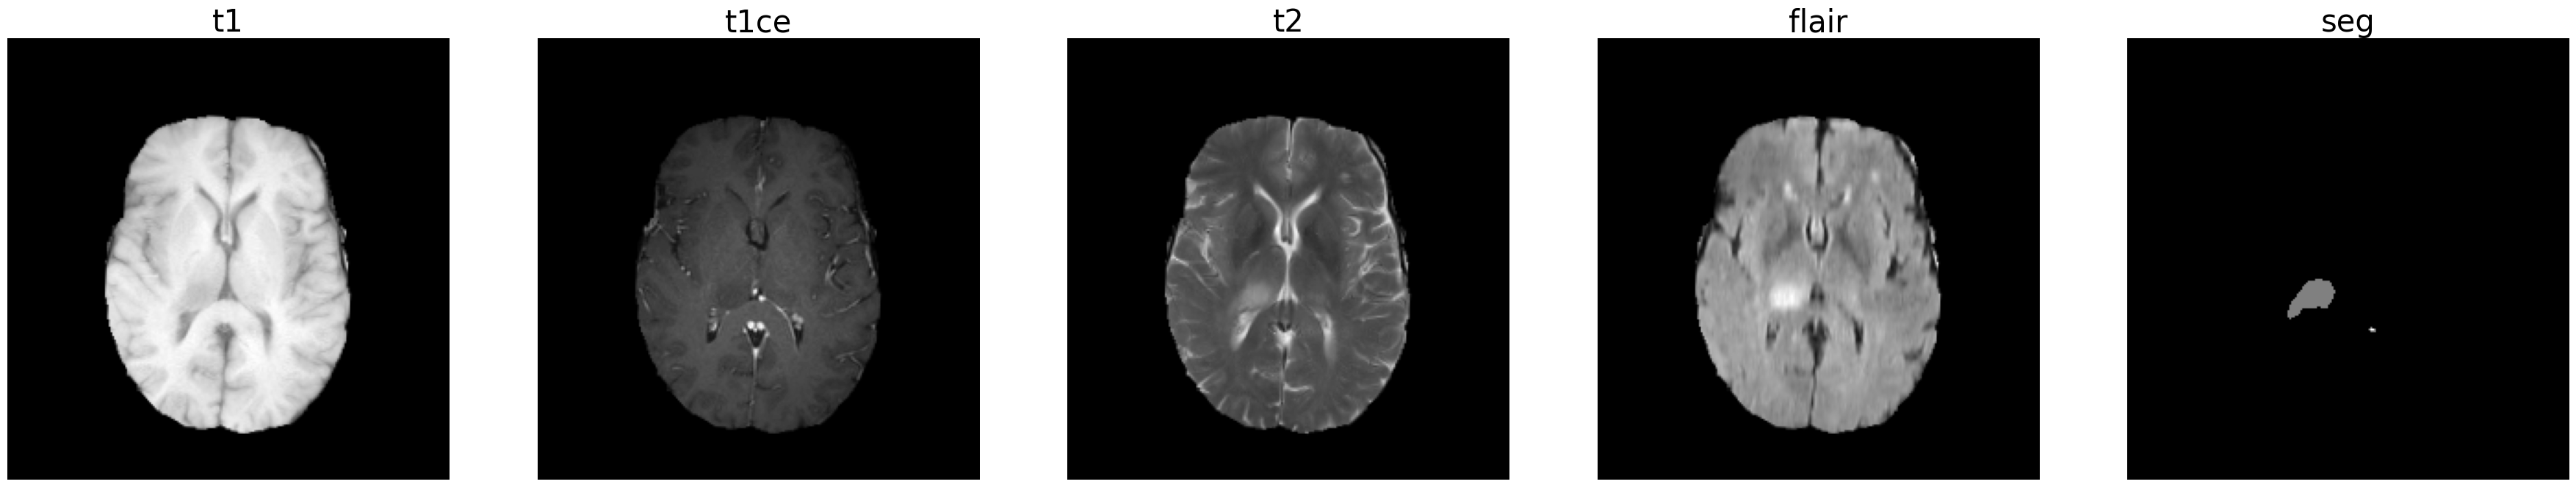

In [20]:
# Visualizing one patient's images and segmentation masks
# Choose a patient ID to visualize
patient_id = train_ids[12]  # Replace 'train_ids[12]' with the desired patient ID

# Read images for the chosen patient
pt_img_dict = read_patient_niftis(patient_id)

# Visualize the images
plt.figure(figsize=(45, 30))  # Specifying the overall grid size
for i, (key, value) in enumerate(pt_img_dict.items()):
    plt.subplot(1, 5, i + 1)
    plt.imshow(value._dataobj[:, :, value.shape[-1] // 2].T, cmap='gray')  # Mid-volume slice, transposed
    plt.axis('off')
    plt.title(key, fontsize=30)
plt.show()


A quick recap on MRI basics: https://my-ms.org/mri_basics.html

In [21]:
# For this semantic segmentation task, we will use T2 images.
# And we will focus on binary or whole tumor (WT) segmentation. In order to do so we will assign the same pixel intensity (1) to the 3 tumor sub regions (1, 2, 4)

t2_img = pt_img_dict['t2'].get_fdata()
seg_img = pt_img_dict['seg'].get_fdata()

def normalize(input_image = t2_img,
              input_mask = seg_img,
              percentile = 0.001,
              eps = 0.0000001):
    """
    Will read the input image and normalize the image between 0 and 1.
    Will read the input mask and assign pixel value 1 to all tumor subregions (1, 2, 4).
    input_image: default is t2_img, the image to be segmented.
    input_mask: default is seg_img, the ground truth or label.
    """
    img_array = np.ndarray.flatten(input_image)
    min_img, max_img = np.quantile(img_array, percentile), np.quantile(img_array, 1-percentile)
    img_normalized = ((input_image-min_img)/(max_img-min_img+eps)*255).astype(np.uint8)
    img_normalized = tf.cast(img_normalized, tf.float32) / 255

    mask_normalized = np.where(input_mask >=1, 1, 0)
    return img_normalized, mask_normalized


Why is image normalizaton needed: https://arthurdouillard.com/post/normalization/

What are the different types of normalization: https://towardsdatascience.com/different-types-of-normalization-in-tensorflow-dac60396efb0

2025-02-03 22:48:50.512134: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/patel.pranav2/.local/lib/python3.9/site-packages/cv2/../../lib64:/shared/EL9/explorer/cuda/12.1.1/lib64:/shared/EL9/explorer/anaconda3/2024.06/lib:/shared/EL9/explorer/nodejs/v22.11.0/lib
2025-02-03 22:48:50.512240: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/patel.pranav2/.local/lib/python3.9/site-packages/cv2/../../lib64:/shared/EL9/explorer/cuda/12.1.1/lib64:/shared/EL9/explorer/anaconda3/2024.06/lib:/shared/EL9/explorer/nodejs/v22.11.0/lib
2025-02-03 22:48:50.512321: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loa

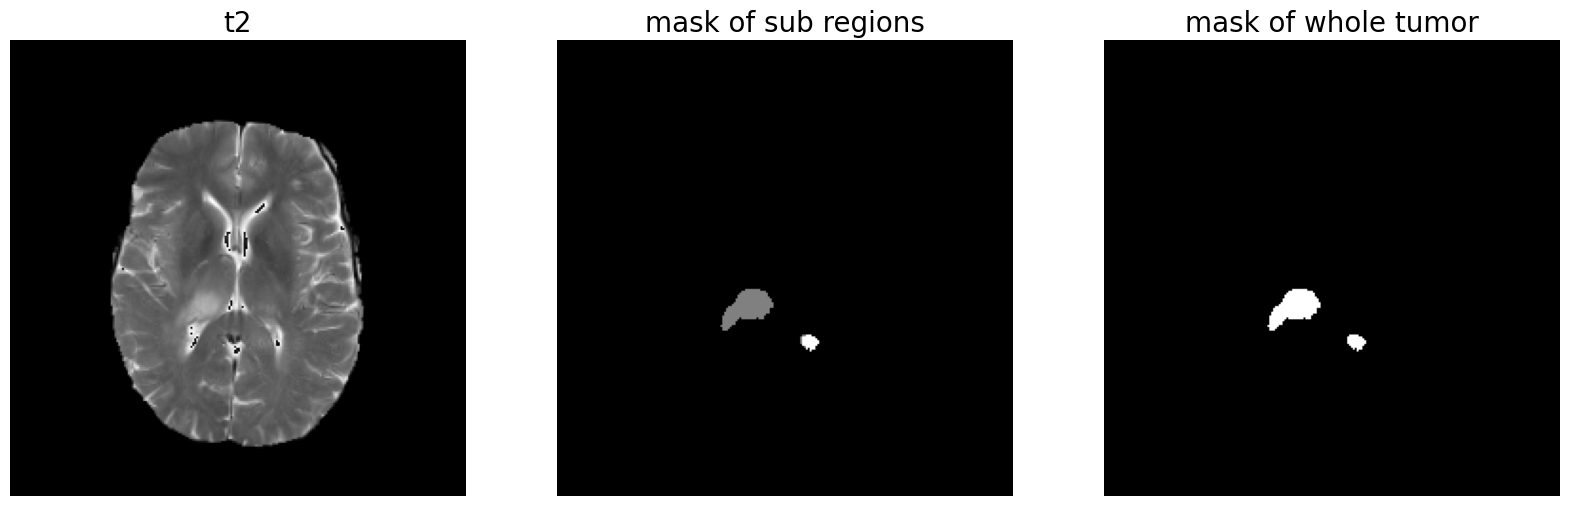

In [22]:
# Let's look at the images after normalizing
img, mask = normalize(t2_img, seg_img)
plt.figure(figsize=(20,30))
plt.subplot(1,3,1)
plt.imshow(tf.transpose(img[:,:,78]), cmap = 'gray')
plt.axis('off')
plt.title('t2', fontsize=20)
plt.subplot(1,3,2)
plt.imshow(tf.transpose(seg_img[:,:,78]), cmap = 'gray')
plt.axis('off')
plt.title('mask of sub regions', fontsize=20)
plt.subplot(1,3,3)
plt.imshow(tf.transpose(mask[:,:,78]), cmap = 'gray')
plt.axis('off')
plt.title('mask of whole tumor', fontsize=20)
plt.show()

## Step 4: Let's take a look at the performance metrics commonly used in semantic segmentation.

The 2 common ones are
- Dice
- Jaccard/Intersection of Union (IoU)

Both Dice and Jaccard indices are bounded between 0 and 1 with 0 indicating completely inaccurate model prediction and 1 indicating completely accurate model prediction.

Performance metrics in image segmentation: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

In [23]:
# Dice
def dice_coef(y_true, y_pred):
    """
    Dice coefficient for semantic segmentation.

    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))

    y_true: The ground truth tensor.
    y_pred: The predicted tensor
    smooth: Smoothing factor. Default is 100.
    """

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Jaccard/IoU
def jacard_coef(y_true, y_pred):
    """
    Jaccard coefficient for semantic segmentation. Also known as the IOU loss.

    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))

    y_true: The ground truth tensor.
    y_pred: The predicted tensor
    smooth: Smoothing factor. Default is 100.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

## Step 5: Let's take a look at loss functions for semantic segmentation.

The default choice of loss function for segmentation and other classification tasks is Binary Cross-Entropy (BCE). Here since the metric  Dice or Jaccard Coefficient is being used to judge model performance, the loss functions that are derived from these metrics - typically in the form 1 - f(x) where f(x) is the metric in question.

Loss functions in image segmentation: https://medium.com/@junma11/loss-functions-for-medical-image-segmentation-a-taxonomy-cefa5292eec0

In [24]:
# The 2 loss functions we will look at are Dice and Jaccard loss
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

## Step 6: Now comes the most interesing bit of our learning!

We will now build the Unet model we are going to use for semantic segmentation of WT.

What is a UNet: https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47

Video explaining UNet: https://www.youtube.com/watch?v=azM57JuQpQI


In [25]:
# Define the UNet model
def get_unet(input_shape=(None, None, 1),
                  num_classes=1):
    inputs = Input(shape=input_shape)
    down1 = Conv2D(64, (3, 3), activation = 'relu', padding='same')(inputs)
    down1 = BatchNormalization()(down1)
    down1 = Conv2D(64, (3, 3), activation = 'relu', padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)


    down2 = Conv2D(128, (3, 3), activation = 'relu', padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Conv2D(128, (3, 3), activation = 'relu', padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)


    down3 = Conv2D(256, (3, 3), activation = 'relu', padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Conv2D(256, (3, 3), activation = 'relu', padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)


    down4 = Conv2D(512, (3, 3), activation = 'relu', padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Conv2D(512, (3, 3), activation = 'relu', padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)


    center = Conv2D(1024, (3, 3), activation = 'relu', padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Conv2D(1024, (3, 3), activation = 'relu', padding='same')(center)
    center = BatchNormalization()(center)


    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), activation = 'relu', padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Conv2D(512, (3, 3), activation = 'relu', padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Conv2D(512, (3, 3), activation = 'relu', padding='same')(up4)
    up4 = BatchNormalization()(up4)


    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), activation = 'relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Conv2D(256, (3, 3), activation = 'relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Conv2D(256, (3, 3), activation = 'relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)


    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), activation = 'relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Conv2D(128, (3, 3), activation = 'relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Conv2D(128, (3, 3), activation = 'relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)


    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), activation = 'relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Conv2D(64, (3, 3), activation = 'relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Conv2D(64, (3, 3), activation = 'relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)


    classify = Conv2D(1, (1, 1), activation='sigmoid')(up1)

    model = Model(inputs=inputs, outputs=classify)
    model.compile(optimizer=Adam(learning_rate=0.00005), loss=dice_coef_loss, metrics=[dice_coef])
    return model

model = get_unet()

Instead of constant learning rate, how to use a gradually decreasing learning rate instead: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler

Lets visualize the model now!

In [26]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Step 7: Let's do some model training now.

In [27]:
# Let's define a function to create numpy arrays of training, validation and test images.

# For the sake of simplicity, we will use only the middle slice of each volume for this experiment.

X = []
Y = []

def create_numpy_array(patient_ids:str,
                       DATA_PATH):
    X = []
    Y = []

    for i in range(len(patient_ids)):
        pt_img_dict = read_patient_niftis(patient_ids[i],
                                          niftis_to_load = ['t2', 'seg'],
                                          data_path = DATA_PATH)

        images = []
        for j, (key, value) in enumerate(pt_img_dict.items()):
            images.append(value._dataobj[:, :, value.shape[-1]//2].T)

        image, mask = normalize(images[0], images[1])
        X.append(expand_dims(image, axis=2))
        Y.append(expand_dims(mask, axis=2))

    return np.asarray(X), np.asarray(Y)



In [28]:
# Now using the defined function, let's create train, validation and test numpy arrays.
X_train, Y_train = create_numpy_array(train_ids, TRAIN_DATA_PATH)
X_val, Y_val = create_numpy_array(val_ids, TRAIN_DATA_PATH)
X_test, Y_test = create_numpy_array(test_ids, TRAIN_DATA_PATH)

Now we will read the .npy files and start our model training!We have a numpy arrays already created and saved

In [29]:
# Let's confirm the size of the training, validation and test arrays.
print(f'There are {len(X_train)} images in training set')
print(f'There are {len(X_val)} images in validation set')
print(f'There are {len(X_test)} images in test set')


There are 236 images in training set
There are 59 images in validation set
There are 74 images in test set


Text(0.5, 1.0, 'mask')

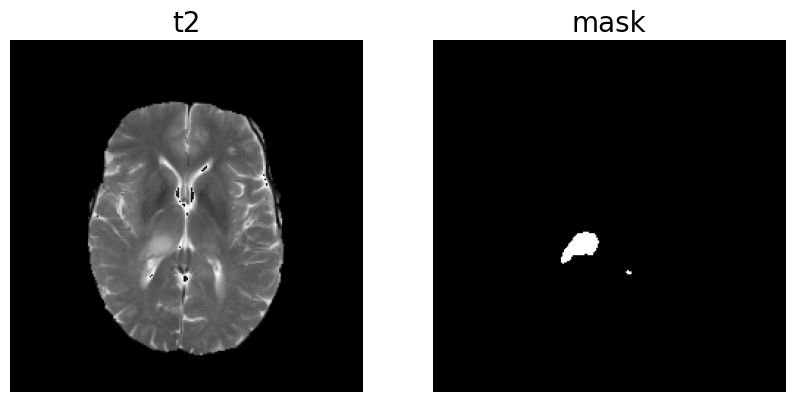

In [30]:
# Visualize the images
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(X_train[12][:,:,0], cmap = 'gray')
plt.axis('off')
plt.title('t2', fontsize=20)
plt.subplot(1,2,2)
plt.imshow(Y_train[12][:,:,0], cmap = 'gray')
plt.axis('off')
plt.title('mask', fontsize=20)

What are tensor datasets: https://tensorflow.google.cn/guide/data

In [31]:
# Lets create tensor datasets from numpy arrays
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
dataset_train = dataset_train.map(lambda x, y: {'image': x, 'segmentation_mask': y})
dataset_val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
dataset_val = dataset_val.map(lambda x, y: {'image': x, 'segmentation_mask': y})
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
dataset_test = dataset_test.map(lambda x, y: {'image': x, 'segmentation_mask': y})

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


/home/patel.pranav2/.local/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [32]:
# Let's create image loader to resize the image
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    return input_image, input_mask

Understanding difference between batch and epoch in deep learning: https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

In [33]:
TRAIN_LENGTH = len(train_ids)
BATCH_SIZE = 4
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

What does AUTOTUNE do: https://www.tensorflow.org/guide/data_performance

In [34]:
# Resize the image using load_image function defined earlier
train_images = dataset_train.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_images = dataset_val.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset_test.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [35]:
# Build the input pipeline, applying the Augmentation after batching the inputs.
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

val_batches = val_images.batch(BATCH_SIZE)
test_batches = test_images.batch(BATCH_SIZE)

In [36]:
# Define a function to visualize an image example and its corresponding mask from the dataset.
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
      plt.subplot(1, len(display_list), i+1)
      plt.title(title[i])
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap = 'gray')
      plt.axis('off')
    plt.show()

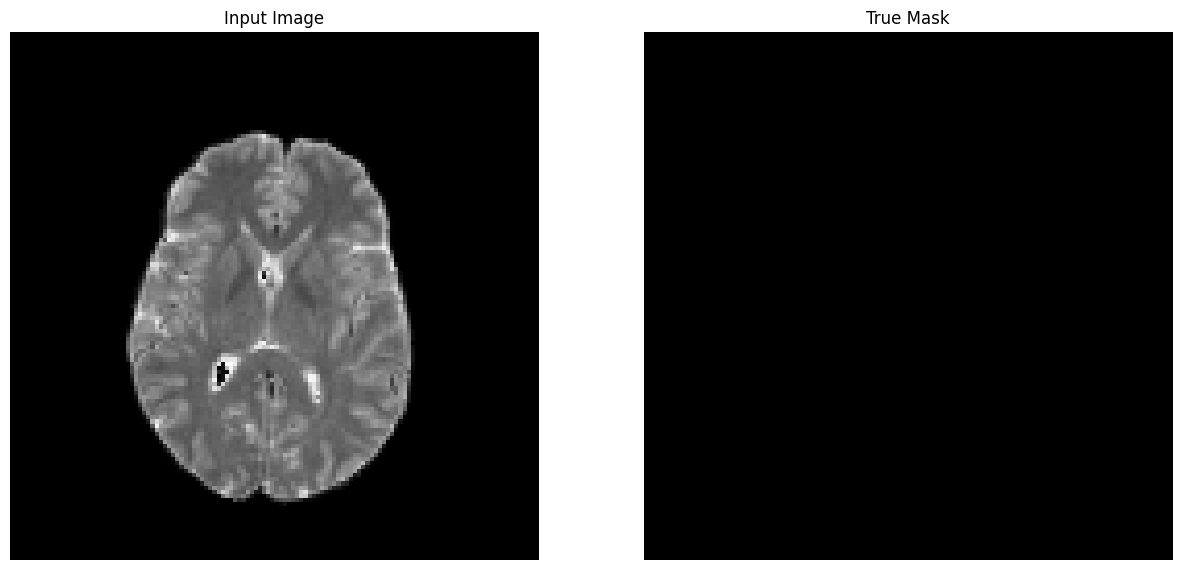

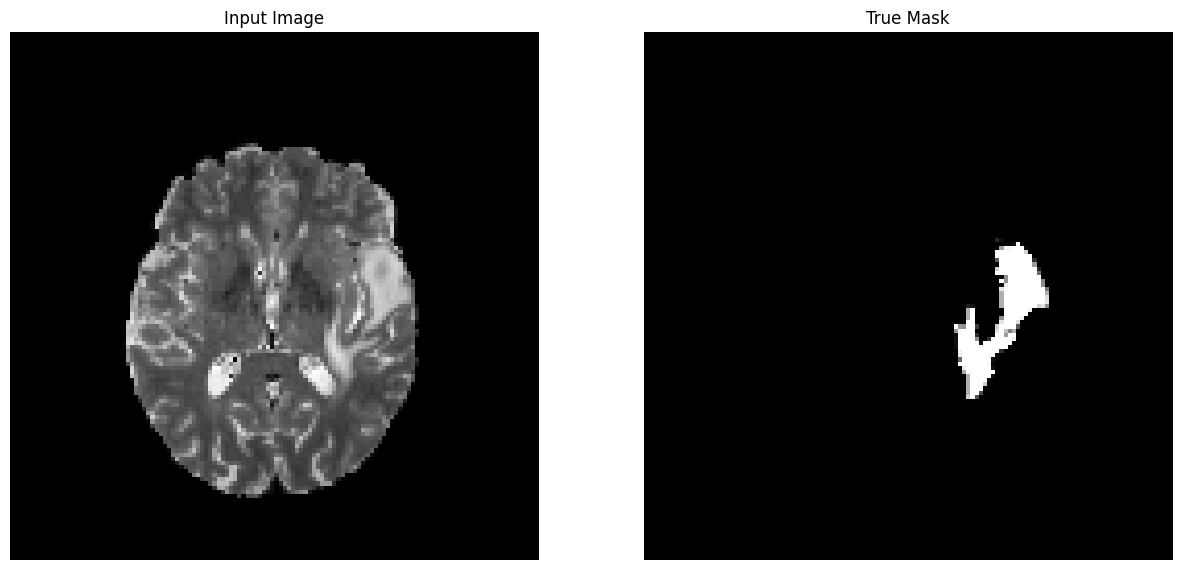

In [37]:
# Visualize an image example and its corresponding mask from the dataset batches.
for images, masks in train_batches.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

Do you notice the change in image resolution of the above images as compared to the original images? The previous images look sharper. This is because we resized the images to 128 x 128. You can play with the load_image module and change the image size to see if that affects the model performance!

In [38]:
# Let's write a function to show the predictions
def show_predictions(dataset=None, num=1):
    if dataset:
      for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        display([image[0], mask[0], pred_mask[0]])
    else:
      display([sample_image, sample_mask,
              model.predict(sample_image[tf.newaxis, ...])])


In [39]:
# Let's train the model now
smooth = 1.
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(val_ids)//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_batches)


Epoch 1/50
59/59 [==============================] - 187s 3s/step - loss: -0.1581 - dice_coef: 0.1581 - val_loss: -0.0458 - val_dice_coef: 0.0458
Epoch 2/50
59/59 [==============================] - 187s 3s/step - loss: -0.2217 - dice_coef: 0.2217 - val_loss: -0.0453 - val_dice_coef: 0.0453
Epoch 3/50
59/59 [==============================] - 186s 3s/step - loss: -0.2578 - dice_coef: 0.2578 - val_loss: -0.0638 - val_dice_coef: 0.0638
Epoch 4/50
59/59 [==============================] - 186s 3s/step - loss: -0.2973 - dice_coef: 0.2973 - val_loss: -0.2567 - val_dice_coef: 0.2567
Epoch 5/50
59/59 [==============================] - 187s 3s/step - loss: -0.3203 - dice_coef: 0.3203 - val_loss: -0.1445 - val_dice_coef: 0.1445
Epoch 6/50
59/59 [==============================] - 187s 3s/step - loss: -0.3331 - dice_coef: 0.3331 - val_loss: -0.4493 - val_dice_coef: 0.4493
Epoch 7/50
59/59 [==============================] - 188s 3s/step - loss: -0.3447 - dice_coef: 0.3447 - val_loss: -0.2699 - val_dic

## Step 8: Now let's take a look at the learning curve.

Learning curves are a widely used diagnostic tool in machine learning for algorithms that learn from a training dataset incrementally. The model can be evaluated on the training dataset and on a hold out validation dataset after each update during training and plots of the measured performance can created to show learning curves.


Importance of learning curves: https://towardsdatascience.com/learning-curve-to-identify-overfitting-underfitting-problems-133177f38df5

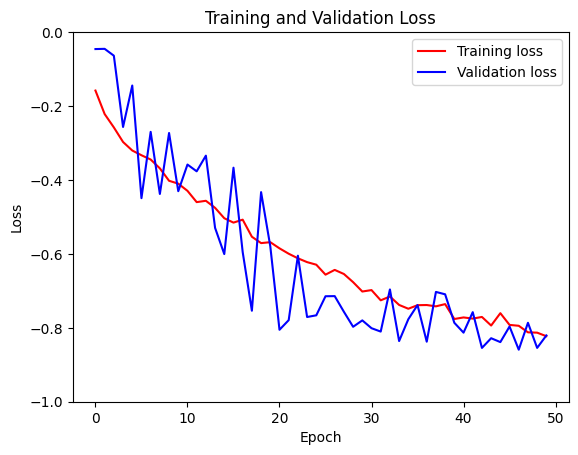

In [40]:
# Let's take a look at the learning curve now
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([-1, 0])
plt.legend()
plt.show()

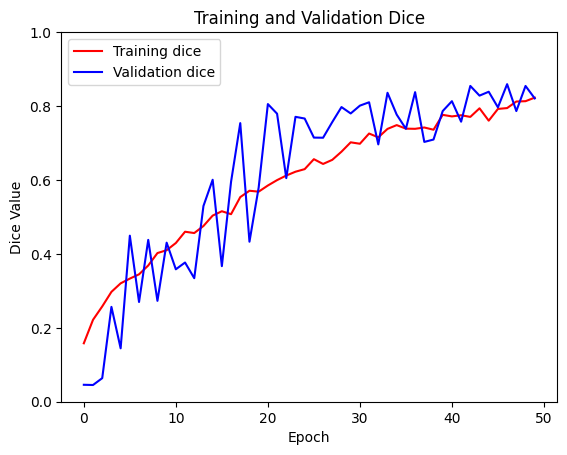

In [41]:
# Let's also look at how the dice coef changes (Since the loss function is also derived as 1 - dice_coef, you can skip looking at this)
dice = model_history.history['dice_coef']
val_dice = model_history.history['val_dice_coef']

plt.figure()
plt.plot(model_history.epoch, dice, 'r', label='Training dice')
plt.plot(model_history.epoch, val_dice,'b', label='Validation dice')
plt.title('Training and Validation Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

How do we choose number of epochs? Is there a way to stop training the model when it starts overfitting: https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/

Tensorflow early stopping: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

## Step 9: Now we will look at the model predictions in the validation and test sets.

1/1 [==============================] - 1s 680ms/step


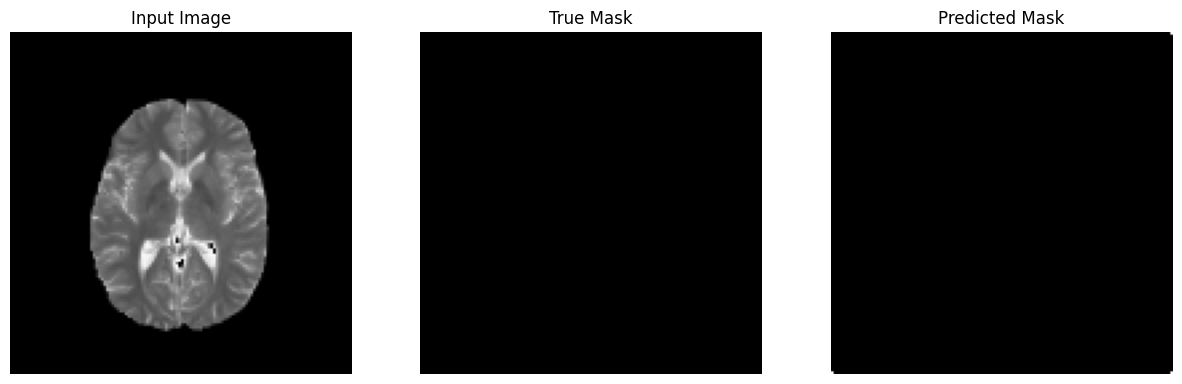

1/1 [==============================] - 1s 609ms/step


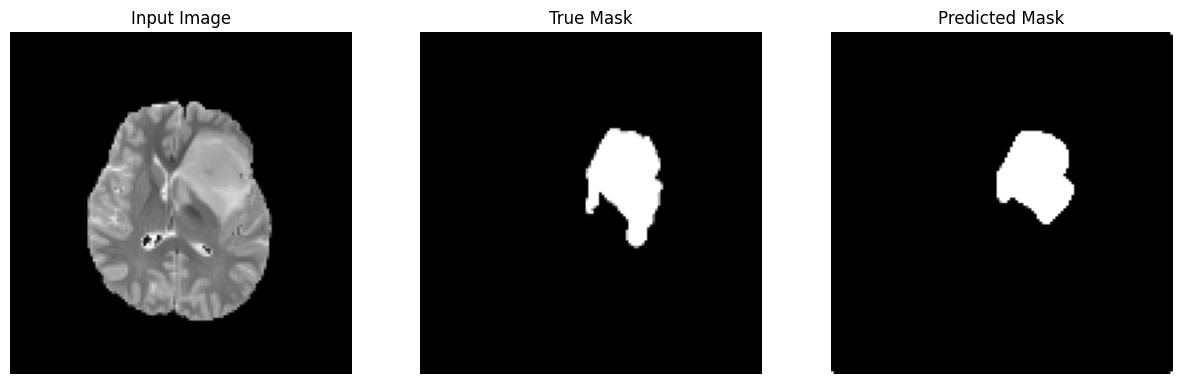

1/1 [==============================] - 1s 613ms/step


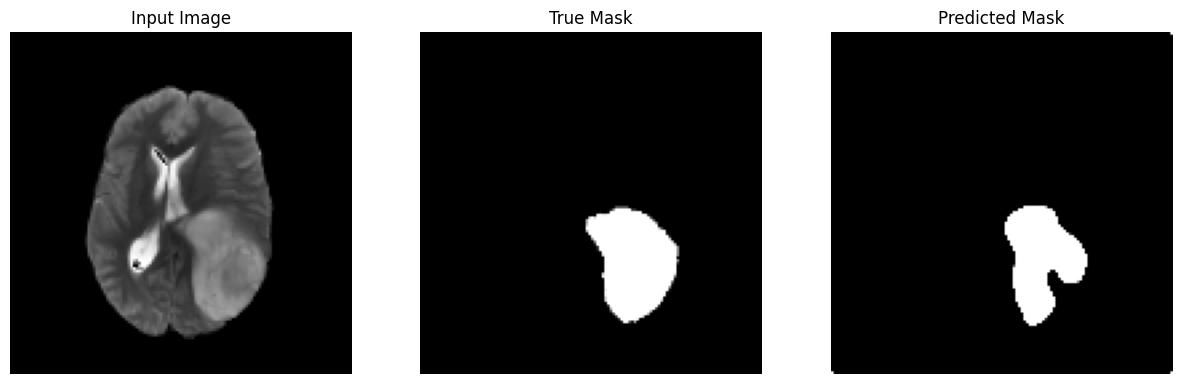

In [42]:
show_predictions(val_batches, 3)

1/1 [==============================] - 1s 643ms/step


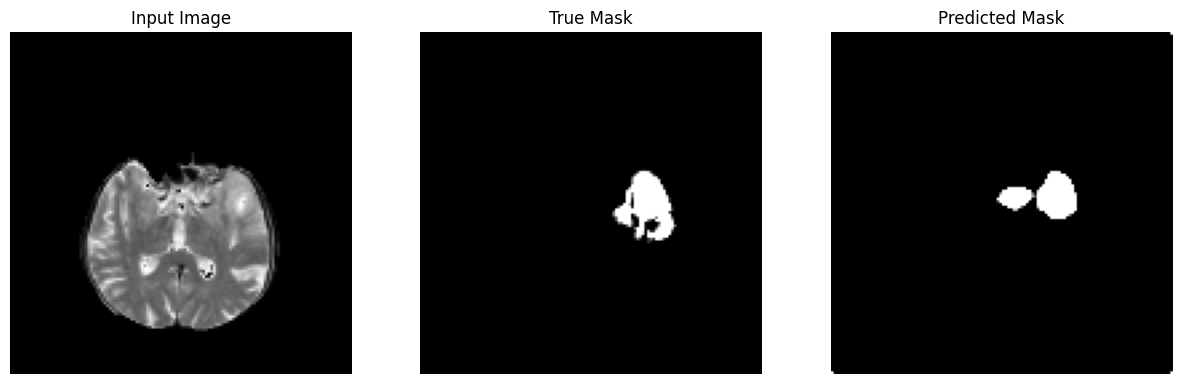

1/1 [==============================] - 1s 588ms/step


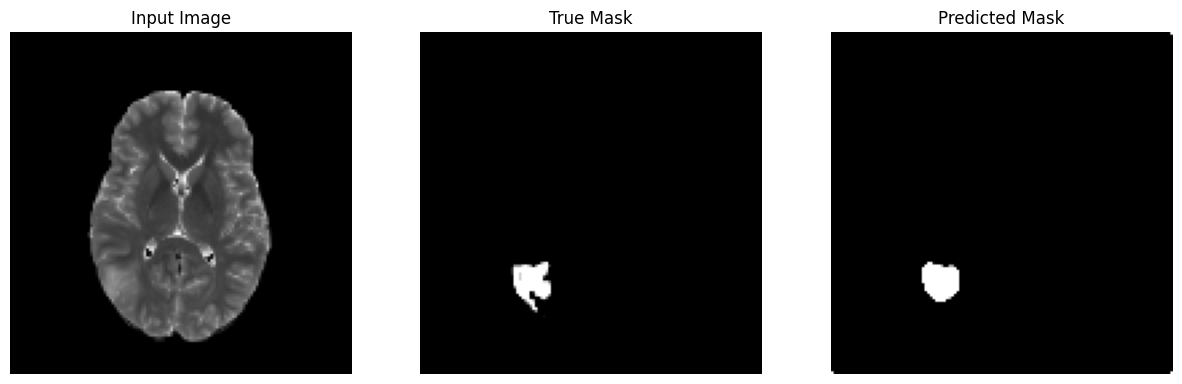

1/1 [==============================] - 1s 588ms/step


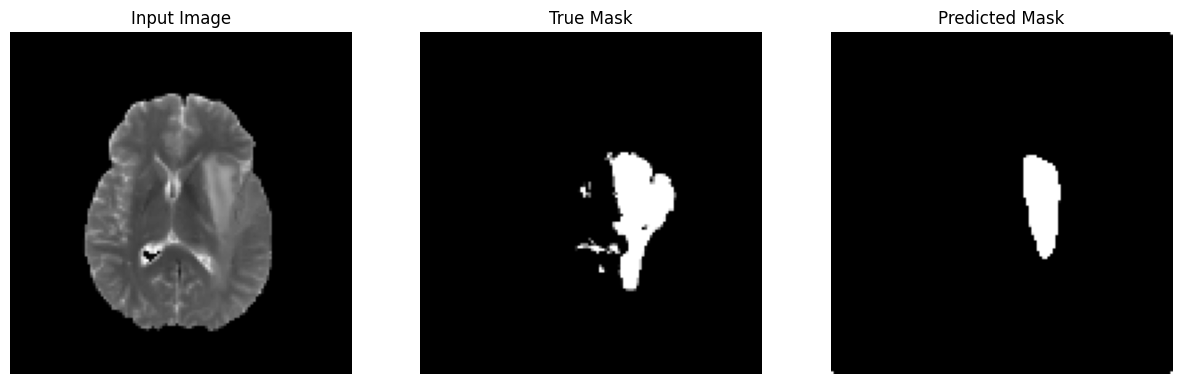

In [43]:
show_predictions(test_batches, 3)

## Step 10: What next? There are so many things you could do here. So it is now time to play!

As a home-work or self learning task, you can try a variety of experiments to understand how the model performance is affected.

You can also do some of this as your term project.  

Try to think about what could improve the model performance?
1. Will increasing the size of training set help? We are just using 1 slice per volume, will using more slices help?
2. Will changing the hyper-parameters like optimizer, learning rate, loss function, epochs, batch size improve the model performance? For ex. you have already learnt about BCE loss function. What will happen if you change the loss function?
3. Will changing the type of image help? Is T2 the right image for the model? Should I try with T1/T1CE/FLAIR?
4. Can I use 2/3 channel input image instead of single channel? Can have 3 different images in the 3 channels, say T1, T2 and FLAIR? Will that give the model more information to perform better?
5. How is the learning curve for this trained model? Is it underfitting? Does it need more training? How much training is enough and when should I stop?
6. Can I modify the Unet model to improve the performance? What can I change?

And there is so much more! This is just a starting point. Model training and hyper-parameter tuning is the time consuming of any deep learning project.

Next what?
In this example we learnt a binary or 2 class segmentation problem. It can be extended to a multi-class problem.

Another fun task to do would be to try a multi-class segmentation where you can try and predict the different sub-regions of the tumors. What will you need yo modify in the current code to change it to a multi-class problem?

Are there ways to automate hyper-parameter tuning: https://neptune.ai/blog/hyperparameter-tuning-in-python-complete-guide




In [44]:
# Some additional functions defined for model training

# Let's look at an example of how we modify the create_numpy_array module if we want to have a multi channel image (for ex. T1, T2, FLAIR)


X = []
Y = []

def create_numpy_array(patient_ids:str,
                       DATA_PATH):
    X = []
    Y = []

    for i in range(len(patient_ids)):
        pt_img_dict = read_patient_niftis(patient_ids[i],
                                          niftis_to_load = ['t1', 't2', 'flair', 'seg'],
                                          data_path = DATA_PATH)

        images = []

        for j, (key, value) in enumerate(pt_img_dict.items()):
            images.append(value._dataobj[:, :, value.shape[-1]//2].T)

        images_3 = cv2.merge((images[0],images[1],images[2]))
        image, mask = normalize(images_3, images[3])
        X.append(image)
        Y.append(expand_dims(mask, axis=2))

    return np.asarray(X), np.asarray(Y)



In [45]:
# Create training, validation and test numpy arrays using bove defined function
X_train, Y_train = create_numpy_array(train_ids, TRAIN_DATA_PATH)
X_val, Y_val = create_numpy_array(val_ids, TRAIN_DATA_PATH)
X_test, Y_test = create_numpy_array(test_ids, TRAIN_DATA_PATH)

In [46]:
# Let's look at an example of how we change the numpy array if we want to have a multiple slices per volume


X = []
Y = []

def create_numpy_array(patient_ids:str,
                       DATA_PATH):
    X = []
    Y = []

    for i in range(len(patient_ids)):
        pt_img_dict = read_patient_niftis(patient_ids[i],
                                          niftis_to_load = ['t2', 'seg'],
                                          data_path = DATA_PATH)

        images = []
        # Let's say you want 5 slices sampled every 10 slices centered around middle slice
        n = [-20, -10, 0, 10, 20]
        count = -1
        for k in n:
            for j, (key, value) in enumerate(pt_img_dict.items()):
                images.append(value._dataobj[:, :, ((value.shape[-1]//2) + k)].T)
            count = count + 1

            image, mask = normalize(images[count*2], images[(count*2)+1])
            X.append(expand_dims(image, axis=2))
            Y.append(expand_dims(mask, axis=2))

    return np.asarray(X), np.asarray(Y)

In [47]:
# Create training, validation and test numpy arrays using bove defined function
X_train, Y_train = create_numpy_array(train_ids, TRAIN_DATA_PATH)
X_val, Y_val = create_numpy_array(val_ids, TRAIN_DATA_PATH)
X_test, Y_test = create_numpy_array(test_ids, TRAIN_DATA_PATH)